Episode 1: Reward -26.00, Loss 335.6972, Eval MSE 444.0072
Episode 11: Reward -27.00, Loss 355.8056, Eval MSE 442.8958
Episode 21: Reward -572.00, Loss 28567.9102, Eval MSE 452.6838
Episode 31: Reward -451.00, Loss 19600.3984, Eval MSE 421.2443
Episode 41: Reward -310.50, Loss 8825.2715, Eval MSE 529.5894
Episode 51: Reward -287.50, Loss 6418.3442, Eval MSE 464.2134
Episode 61: Reward -108.00, Loss 1809.5963, Eval MSE 539.8253
Episode 71: Reward -82.50, Loss 656.0596, Eval MSE 371.7606
Episode 81: Reward -459.00, Loss 17038.0879, Eval MSE 393.9084
Episode 91: Reward -375.00, Loss 10358.0859, Eval MSE 406.6719


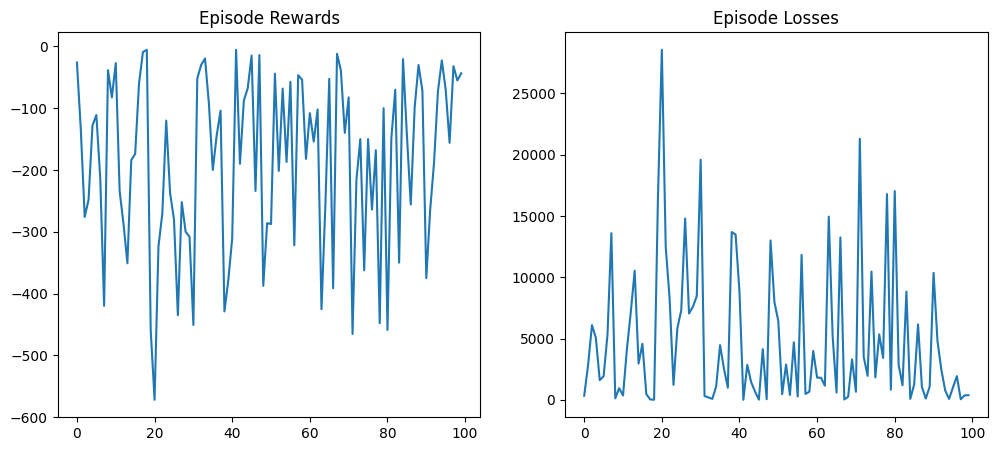

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset (change the path to your local file location)
file_path = 'amazon_delivery.csv'  # Update this path
delivery_data = pd.read_csv(file_path)

# Drop unnecessary columns
delivery_data_cleaned = delivery_data.drop(columns=["Order_ID", "Order_Date", "Order_Time", "Pickup_Time"])

# Encode categorical variables
categorical_columns = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
delivery_data_cleaned = pd.get_dummies(delivery_data_cleaned, columns=categorical_columns)

# Ensure numerical columns are correctly formatted
numeric_columns = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude",
                   "Drop_Latitude", "Drop_Longitude", "Delivery_Time"]
delivery_data_cleaned[numeric_columns] = delivery_data_cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
delivery_data_cleaned = delivery_data_cleaned.dropna()

# Feature Engineering: Calculate Distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat/2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply distance calculation
delivery_data_cleaned["Distance"] = delivery_data_cleaned.apply(lambda row: haversine(
    row["Store_Latitude"], row["Store_Longitude"], row["Drop_Latitude"], row["Drop_Longitude"]), axis=1)

# Drop latitude/longitude columns as they are redundant
delivery_data_cleaned = delivery_data_cleaned.drop(columns=["Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude"])

# Split data for training and testing
X = delivery_data_cleaned.drop(columns=['Delivery_Time'])
y = delivery_data_cleaned['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# PPO Model architecture
def build_ppo_model(input_dim, output_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    action_logits = layers.Dense(output_dim)(x)
    action_probs = layers.Softmax()(action_logits)
    state_value = layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=[action_probs, state_value])
    return model

# Hyperparameters
n_actions = 5
state_dim = X_train.shape[1]
gamma = 0.99
epsilon = 0.2
lambda_ = 0.95
episodes = 100

# Create PPO model
ppo_model = build_ppo_model(state_dim, n_actions)
optimizer = optimizers.Adam(learning_rate=0.0003)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done, log_prob, value):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done, log_prob, value))

    def get_all(self):
        return self.buffer

    def clear(self):
        self.buffer = []

buffer = ReplayBuffer()

# Training metrics
episode_rewards = []
episode_losses = []
evaluation_interval = 10
evaluation_scores = []

def evaluate_ppo(model, X_eval, y_eval, samples=100):
    mse_scores = []
    for _ in range(samples):
        idx = np.random.randint(0, len(X_eval))
        state = X_eval.iloc[idx].values.astype(np.float32)
        true_time = y_eval.iloc[idx]
        action_probs, _ = model.predict(np.array([state]), verbose=0)
        action = np.argmax(action_probs[0])
        action_time_effect = {0: 0.9, 1: 1.0, 2: 1.1, 3: 0.8, 4: 1.2}
        pred_time = true_time * action_time_effect[action]
        mse = (pred_time - true_time) ** 2
        mse_scores.append(mse)
    return np.mean(mse_scores)

# Training loop
batch_size = 64
for episode in range(episodes):
    buffer.clear()
    state_idx = np.random.randint(0, len(X_train))
    state = X_train.iloc[state_idx].values.astype(np.float32)
    target_delivery_time = y_train.iloc[state_idx]
    total_reward = 0
    episode_loss = []
    step = 0
    done = False

    while not done and step < 20:
        action_probs, state_value = ppo_model.predict(np.array([state]), verbose=0)
        action_prob = action_probs[0]
        if np.any(np.isnan(action_prob)) or np.sum(action_prob) < 1e-10:
            print(f"Episode {episode+1}, Step {step}: NaN or invalid probabilities detected!")
            action_prob = np.ones(n_actions) / n_actions
        action = np.random.choice(n_actions, p=action_prob)
        log_prob = np.log(max(action_prob[action], 1e-10))
        action_time_effect = {0: 0.9, 1: 1.0, 2: 1.1, 3: 0.8, 4: 1.2}
        pred_delivery_time = target_delivery_time * action_time_effect[action]
        reward = -abs(pred_delivery_time - target_delivery_time)
        next_state_idx = np.random.randint(0, len(X_train))
        next_state = X_train.iloc[next_state_idx].values.astype(np.float32)
        step += 1
        done = (step >= 20) or (np.random.rand() < 0.05)
        buffer.add(state, action, reward, next_state, done, log_prob, state_value[0][0])
        state = next_state
        total_reward += reward

    experience = buffer.get_all()
    states = np.array([e[0] for e in experience])
    actions = np.array([e[1] for e in experience])
    rewards = np.array([e[2] for e in experience])
    next_states = np.array([e[3] for e in experience])
    dones = np.array([e[4] for e in experience])
    old_log_probs = np.array([e[5] for e in experience])
    values = np.array([e[6] for e in experience])
    advantages = np.zeros_like(rewards)
    returns = np.zeros_like(rewards)
    gae = 0

    for t in reversed(range(len(rewards))):
        if t == len(rewards) - 1:
            next_value = 0 if dones[t] else ppo_model.predict(np.array([next_states[t]]), verbose=0)[1][0][0]
        else:
            next_value = values[t+1]
        delta = rewards[t] + gamma * next_value * (1 - dones[t]) - values[t]
        gae = delta + gamma * lambda_ * (1 - dones[t]) * gae
        advantages[t] = gae
        returns[t] = advantages[t] + values[t]

    advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

    with tf.GradientTape() as tape:
        action_probs_pred, values_pred = ppo_model(states)
        action_probs_pred = tf.gather(action_probs_pred, actions, axis=1, batch_dims=1)
        ratio = tf.exp(tf.math.log(action_probs_pred) - old_log_probs)
        surrogate_loss = tf.minimum(ratio * advantages, tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon) * advantages)
        value_loss = tf.square(returns - values_pred)
        entropy_loss = -tf.reduce_mean(action_probs_pred * tf.math.log(action_probs_pred + 1e-10))
        total_loss = -tf.reduce_mean(surrogate_loss) + 0.5 * tf.reduce_mean(value_loss) - 0.01 * entropy_loss

    grads = tape.gradient(total_loss, ppo_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, ppo_model.trainable_variables))
    episode_rewards.append(total_reward)
    episode_losses.append(total_loss.numpy())

    if episode % evaluation_interval == 0:
        eval_score = evaluate_ppo(ppo_model, X_test, y_test)
        evaluation_scores.append(eval_score)
        print(f"Episode {episode+1}: Reward {total_reward:.2f}, Loss {total_loss.numpy():.4f}, Eval MSE {eval_score:.4f}")

# Save the trained PPO model locally
ppo_model.save('delivery_route_ppo.keras')

# Save results locally
results = {
    'episode_rewards': episode_rewards,
    'episode_losses': episode_losses,
    'evaluation_scores': evaluation_scores
}
np.save('ppo_results.npy', results)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')

plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Episode Losses')
plt.show()